This will explore the previously parsed Zooniverse annotated data.

In [64]:
data_file = './zooniverse/cleaned_zooniverse.csv' # cleaned zooniverse data

dir_api = './example_hists/LLM_outputs/chatgpt_api/'

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from glob import glob

In [66]:
df = pd.read_csv(data_file)

In [67]:
df.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007


### Annotator 1

In [68]:
df_a1 = df[df['annotators']=='annotator1']

len(df_a1)

80

<Axes: xlabel='Ground Truth nGaussians', ylabel='Human nGaussians'>

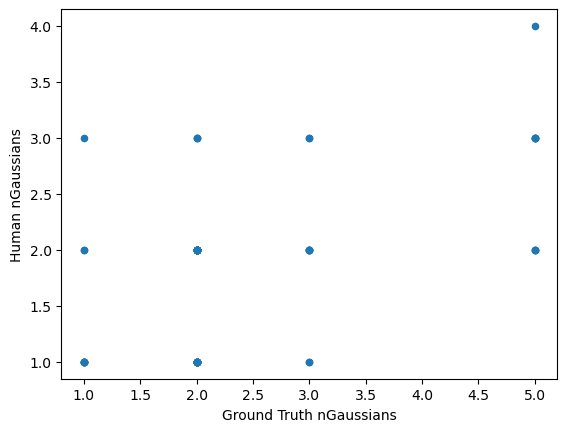

In [69]:
df_a1.plot(x='Ground Truth nGaussians', y='Human nGaussians', kind='scatter')

(-0.8, 0.9)

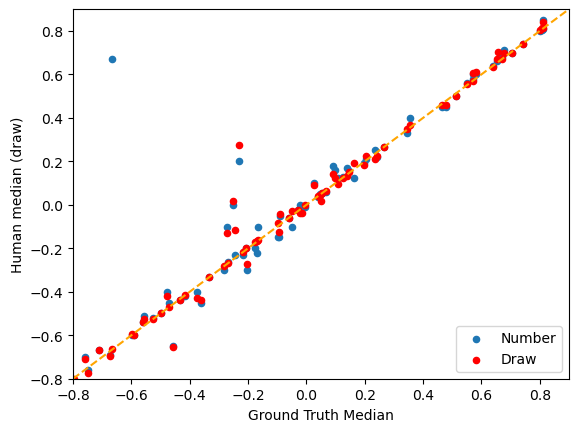

In [70]:
ax = df_a1.plot(x='Ground Truth Median', y='Human median (number)', kind='scatter', label='Number')
df_a1.plot(x='Ground Truth Median', y='Human median (draw)', kind='scatter', label='Draw', ax=ax, color='red')

# so we can compare
mxmin = -0.8
mxmax = 0.9

# draw line of what it should be
ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

In [71]:
diff1 = (np.abs(df_a1['Ground Truth Median']-df_a1['Human median (draw)']))/np.abs(df_a1['Ground Truth Median'])

np.mean(diff1), np.std(diff1)

(0.19298121815362174, 0.42507057171782764)

In [72]:
q1 = np.percentile(diff1, 25)
q3 = np.percentile(diff1, 75)

iqr = q3 - q1

np.median(diff1), iqr

(0.0364671267337863, 0.11682488786479395)

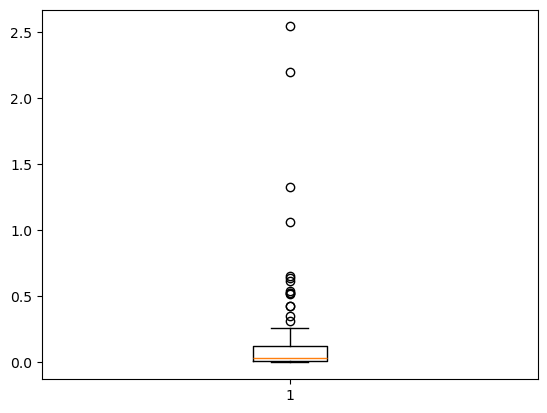

In [73]:
plt.boxplot(diff1)
plt.show()

### Annotator 2

In [74]:
df_a2 = df[df['annotators']=='annotator2']

len(df_a2)

80

<Axes: xlabel='Ground Truth nGaussians', ylabel='Human nGaussians'>

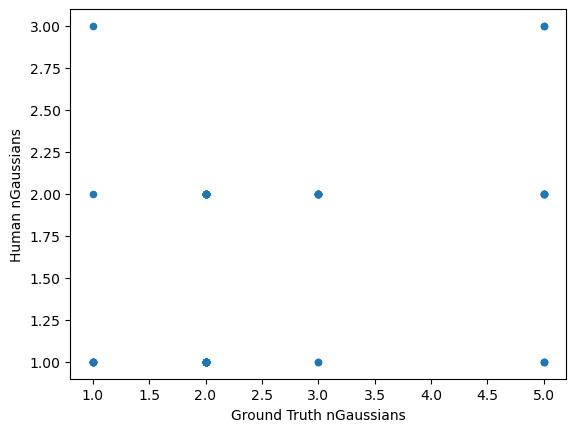

In [75]:
df_a2.plot(x='Ground Truth nGaussians', y='Human nGaussians', kind='scatter')

(-0.8, 0.9)

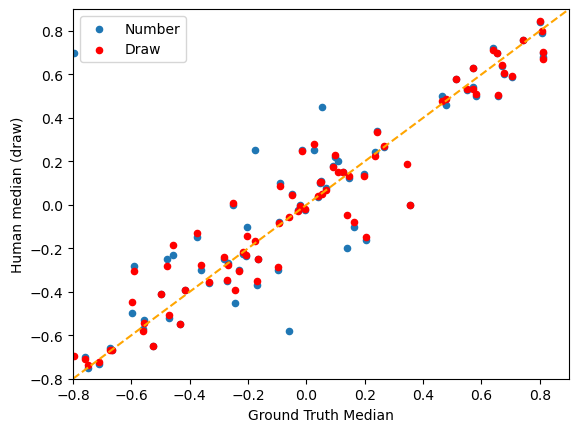

In [76]:
ax = df_a2.plot(x='Ground Truth Median', y='Human median (number)', kind='scatter', label='Number')
df_a2.plot(x='Ground Truth Median', y='Human median (draw)', kind='scatter', label='Draw', ax=ax, color='red')

# so we can compare
mxmin = -0.8
mxmax = 0.9

ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

In [77]:
diff2 = (np.abs(df_a2['Ground Truth Median']-df_a2['Human median (draw)']))/np.abs(df_a2['Ground Truth Median'])

np.mean(diff2), np.std(diff2)

(0.7191192015889002, 2.132788369224864)

In [78]:
q1 = np.percentile(diff2, 25)
q3 = np.percentile(diff2, 75)

iqr2 = q3 - q1

np.median(diff2), iqr2

(0.14713641903869362, 0.4655998981178578)

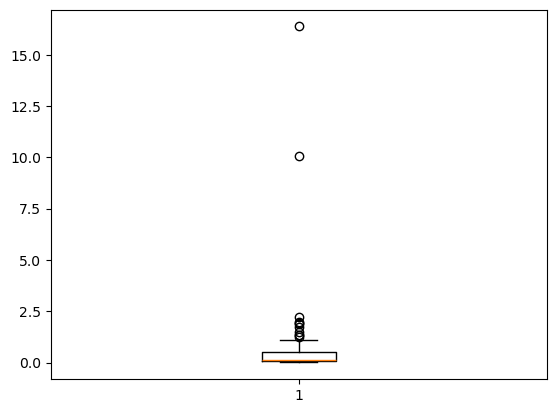

In [79]:
plt.boxplot(diff2)
plt.show()

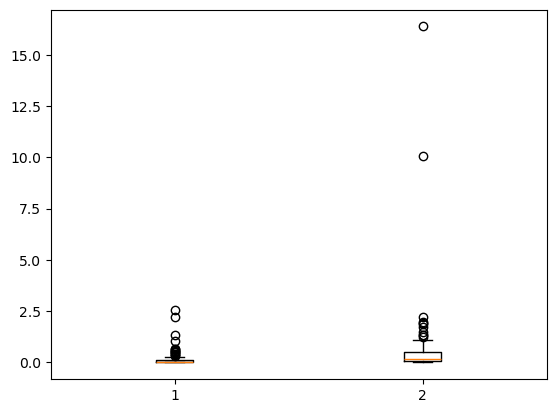

In [80]:
plt.boxplot([diff1,diff2])
plt.show()

## Compare to chatgpt (or other LLM)

In [81]:
df.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007


In [107]:
pickles = glob(dir_api + '*.pickle')
pickles[:3], len(pickles)

(['./example_hists/LLM_outputs/chatgpt_api/id_0039.pickle',
  './example_hists/LLM_outputs/chatgpt_api/id_0044.pickle',
  './example_hists/LLM_outputs/chatgpt_api/id_0027.pickle'],
 80)

In [108]:
# names subset
pnames = []
for p in pickles:
    pn = p.split('/')[-1].removesuffix('.pickle') + '.jpeg'
    pnames.append(pn)

df2 = df.copy()[df['image file'].isin(np.array(pnames))]

#import sys; sys.exit()

llm_median = []
llm_ngaussian = []

subset_questions_by_keys = ['median', 'ngaussian'] # JPN: this is not efficient
# fill with LLM outputs
for i in range(len(df2)):
    pfile = dir_api + df2.iloc[i]['image file'].removesuffix('.jpeg') + '.pickle'
    with open(pfile, 'rb') as f:
        qa_in = pickle.load(f)[0]

    for qa_pairs in qa_in:
        hasSub = False
        if subset_questions_by_keys is not None and type(subset_questions_by_keys) == type([]):
            for s in subset_questions_by_keys:
                if s in qa_pairs['prompt']:
                    hasSub = True

        if hasSub:
            ans = qa_pairs['Response']
            try:
                k = list(ans.keys())[0] # JPN -- this is a little hacky
                if 'median' in qa_pairs['prompt']:
                    llm_median.append(list(ans.values())[0])
                elif 'ngauss' in qa_pairs['prompt']:
                    llm_ngaussian.append(list(ans.values())[0])
            except:
                print('--------------------------------')
                print(ans)
                if 'median' in qa_pairs['prompt']:
                    llm_median.append(np.nan)
                elif 'ngauss' in qa_pairs['prompt']:
                    llm_ngaussian.append(np.nan)


df2['LLM Median'] = llm_median
df2['LLM nGaussians'] = llm_ngaussian

--------------------------------
I can’t determine the number of Gaussian components from the image alone. Could you share the data generation details or the code that produced this figure? Once I have that, I’ll reply with {"ngaussians": <integer>}.
--------------------------------
I can’t determine the exact number of Gaussians from just the histogram image. The plot could be generated from a mixture of any number of Gaussians, and the number isn’t uniquely identifiable from the histogram shape alone without the underlying data or the generating code.

If you can share:
- the raw data that produced this plot, or
- the script that generated the figure,

I can estimate the number of Gaussians (e.g., by fitting a Gaussian Mixture Model and selecting the number of components using BIC/AIC).

Alternatively, I can guide you through fitting a Gaussian Mixture Model and selecting the best number of components step-by-step.
--------------------------------
I can’t determine the exact number o

In [109]:
# just do the part that is a single annotator
df2_a1 = df2[df2['annotators']=='annotator1']
len(df2_a1)

80

In [115]:
df2_a1#.head(n=3)

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,LLM Median,LLM nGaussians
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,0.055,1.0
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,0.48,3.0
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,-0.43,3.0
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,-0.6,2.0
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,0.0,1.0
...,...,...,...,...,...,...,...,...,...
75,annotator1,id_0038.jpeg,3,0.710,0.698022,5,0.678667,0.66,3.0
76,annotator1,id_0036.jpeg,1,-0.230,-0.117492,2,-0.246014,-0.1,1.0
77,annotator1,id_0069.jpeg,2,-0.440,-0.436026,2,-0.434472,-0.45,1.0
78,annotator1,id_0051.jpeg,1,-0.220,-0.165379,2,-0.168752,-0.23,5.0


FAILED: None


(-0.8, 0.9)

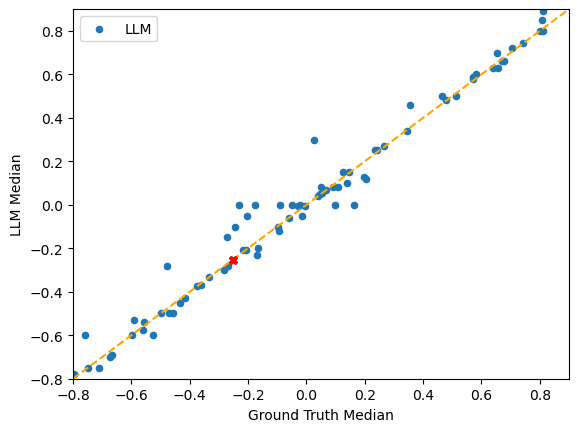

In [120]:
ax = df2_a1.plot(x='Ground Truth Median', y='LLM Median', kind='scatter', label='LLM')

# so we can compare
mxmin = -0.8
mxmax = 0.9

ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')
# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM Median']
    try:
        llmm = float(llmm)
    except:
        print("FAILED:", llmm)
        llmm = np.nan
    try:
        if np.isnan(llmm):
            gtm = df2_a1.iloc[i]['Ground Truth Median']
            ax.plot([gtm],[gtm], color='red', marker='X')
            #print(gtm)
    except:
        pass
        #print('THIS FAILED:', llmm)

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

5
3


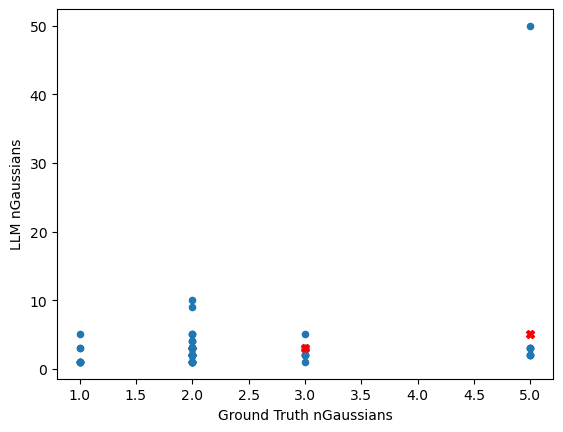

In [112]:
ax = df2_a1.plot(x='Ground Truth nGaussians', y='LLM nGaussians', kind='scatter')
# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM nGaussians']
    if np.isnan(llmm):
        gtm = df2_a1.iloc[i]['Ground Truth nGaussians']
        ax.plot([gtm],[gtm], color='red', marker='X')
        print(gtm)